In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install rdkit
from google.colab import drive
drive.mount('/content/drive')
!python -m pip install git+https://github.com/EBjerrum/molvecgen

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Cloning https://github.com/EBjerrum/molvecgen to /tmp/pip-req-build-oo2965v4
  Running command git clone --filter=blob:none --quiet https://github.com/EBjerrum/molvecgen /tmp/pip-req-build-oo2965v4
  Resolved https://github.com/EBjerrum/molvecgen to commit f81d5aade18bea60882f5845877f6283366bbe91
  Preparing metadata (setup.py) ... done


In [ ]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pprint import pprint
from molvecgen.vectorizers import SmilesVectorizer

In [ ]:
df = pd.read_excel('/content/sample_data/1400.xlsx')

In [ ]:
df['SI'] = df['CC50-MDCK, mmg/ml']/df['IC50, mmg/ml']
df['S_leng'] = df['SMILES'].str.len ()

In [ ]:
df = df[df.SI <= 100]
df = df[df['IC50, mmg/ml'] < 250]
df = df[df['CC50-MDCK, mmg/ml'] < 250]
df = df[df.S_leng < 120]
df = df[df.SI <= 100]
df = df[df.S_leng < 140]
df = df[df['IC50, mmg/ml'] < 310]

In [ ]:
df.columns

Index(['Title', 'IC50, mmg/ml', 'CC50-MDCK, mmg/ml', 'SI', 'Molecular weight',
       'Hydrogen bond acceptors', 'Hydrogen bond donors', 'Polar SA', 'SMILES',
       'Pictures', 'S_leng'],
      dtype='object')

In [ ]:
df_w = df[[ 'IC50, mmg/ml', 'SMILES']]

## Анализ данных

In [ ]:
df[df['IC50, mmg/ml'] < 250]

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,Pictures,S_leng
2,1008-Ya-187,9.9,144.0,14.545455,250.431,1,0,15.60,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,52.0,41
4,1010-Ya-208,39.4,143.0,3.629442,239.361,2,0,29.54,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,54.0,44
13,1018-As-105,13.5,73.0,5.407407,641.133,2,0,24.72,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N\CC[N+](CC)(CC)...,63.0,102
14,1019-YA-214,50.0,41.5,0.830000,472.674,6,0,77.32,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N/CCOC(=O)CCC(=O...,64.0,82
15,1031-ОЛ7-144-1,6.4,53.0,8.281250,431.406,8,2,123.02,CC(=O)C(C1=O)=C(O)C=C2Oc(c3[C@@]12C)c4c(c(C)c3...,65.0,68
...,...,...,...,...,...,...,...,...,...,...,...
1409,CHEMBL5176004,199.1,199.1,1.000000,220.274,4,0,55.99,O=C1C[C@@H](CC2)C(C)(C)[C@]12c(on3)nc3C,NaN,39
1415,CHEMBL4294644,150.2,150.2,1.000000,154.254,1,1,20.23,C[C@]12C(C)(C)[C@@H](CC2)C[C@@H]1O,NaN,34
1429,CHEMBL154,3.7,230.3,62.243243,230.266,1,0,46.53,O=C(O)[C@@H](C)c(c1)ccc(c12)cc(cc2)OC,NaN,37
1448,CHEMBL3040734,29.1,176.3,6.058419,139.243,0,0,26.02,C[C@H](N)[C@H]([C@H]12)C[C@@H](C1)CC2,NaN,37


In [ ]:
df_v = df[['IC50, mmg/ml', 'CC50-MDCK, mmg/ml', 'SI', 'Molecular weight',
       'Hydrogen bond acceptors', 'Hydrogen bond donors', 'Polar SA', 'S_leng']]

In [ ]:
df_v = df_v[df_v.SI < 500]
df_v = df_v[df_v.SI > 0.1]
df_v = df_v[df_v.S_leng < 140]
df_v = df_v[df_v.S_leng > 10]
df_v

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,S_leng
2,9.9,144.0,14.545455,250.431,1,0,15.60,41
4,39.4,143.0,3.629442,239.361,2,0,29.54,44
13,13.5,73.0,5.407407,641.133,2,0,24.72,102
14,50.0,41.5,0.830000,472.674,6,0,77.32,82
15,6.4,53.0,8.281250,431.406,8,2,123.02,68
...,...,...,...,...,...,...,...,...
1409,199.1,199.1,1.000000,220.274,4,0,55.99,39
1415,150.2,150.2,1.000000,154.254,1,1,20.23,34
1429,3.7,230.3,62.243243,230.266,1,0,46.53,37
1448,29.1,176.3,6.058419,139.243,0,0,26.02,37


In [ ]:
df_v.describe()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,S_leng
count,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000
mean,20.808273,62.282441,12.368748,360.738706,3.433090,1.159367,73.402263,55.945255
std,28.696226,56.647975,19.158684,108.193531,2.269273,1.391694,44.133364,16.160000
min,0.004219,0.031928,0.108202,139.243000,0.000000,0.000000,0.000000,16.000000
25%,2.700000,17.150000,1.678924,284.315750,2.000000,0.000000,38.770000,46.000000
50%,8.100000,43.900000,4.267857,345.306000,3.000000,1.000000,67.130000,53.000000
75%,30.000000,93.400000,13.182895,418.491000,4.000000,2.000000,99.330000,63.000000
max,200.000000,243.000000,100.000000,811.002000,14.000000,8.000000,270.280000,119.000000


import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_41, *['IC50, mmg/ml'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_42, *['CC50-MDCK, mmg/ml'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_43, *['SI'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_44, *['Molecular weight'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(_df_45, *['IC50, mmg/ml', 'CC50-MDCK, mmg/ml'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(_df_46, *['CC50-MDCK, mmg/ml', 'SI'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(_df_47, *['SI', 'Molecular weight'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(_df_48, *['Molecular weight', 'Hydrogen bond acceptors'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_49, *['IC50, mmg/ml'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_50, *['CC50-MDCK, mmg/ml'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_51, *['SI'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_52, *['Molecular weight'], **{})
chart

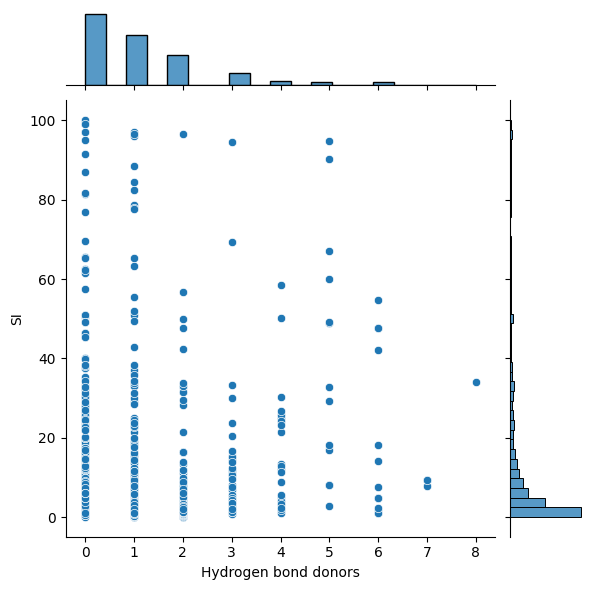

In [ ]:
sns.jointplot(x='Hydrogen bond donors', y='SI', data=df_v);

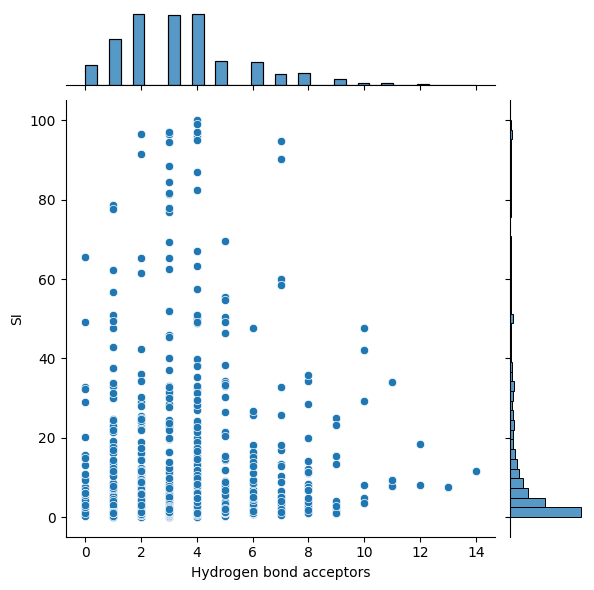

In [ ]:
sns.jointplot(x='Hydrogen bond acceptors', y='SI', data=df_v);

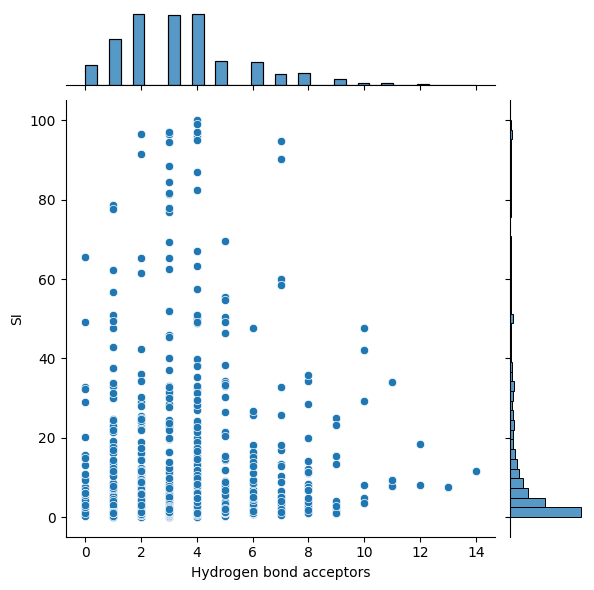

In [ ]:
sns.jointplot(x='Hydrogen bond acceptors', y='SI', data=df_v);

In [ ]:
df_v.corr()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,S_leng
"IC50, mmg/ml",1.000000,0.511734,-0.355282,0.049513,-0.012667,0.009255,0.053922,-0.016509
"CC50-MDCK, mmg/ml",0.511734,1.000000,0.035306,-0.016507,0.011989,-0.018406,0.044498,0.018066
SI,-0.355282,0.035306,1.000000,-0.027467,0.032026,0.021537,0.013342,0.002138
Molecular weight,0.049513,-0.016507,-0.027467,1.000000,0.616584,0.298549,0.706733,0.774384
Hydrogen bond acceptors,-0.012667,0.011989,0.032026,0.616584,1.000000,0.497243,0.770796,0.488370
Hydrogen bond donors,0.009255,-0.018406,0.021537,0.298549,0.497243,1.000000,0.669820,0.277412
Polar SA,0.053922,0.044498,0.013342,0.706733,0.770796,0.669820,1.000000,0.527665
S_leng,-0.016509,0.018066,0.002138,0.774384,0.488370,0.277412,0.527665,1.000000


## Векторайзер

In [ ]:
PandasTools.AddMoleculeColumnToFrame(df_w,'SMILES','Molecule')
df_w[["SMILES","Molecule"]]

/usr/local/lib/python3.10/dist-packages/rdkit/Chem/PandasTools.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,SMILES,Molecule
2,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x7eea1743d070>
4,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,<rdkit.Chem.rdchem.Mol object at 0x7eea1743ceb0>
13,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N\CC[N+](CC)(CC)...,<rdkit.Chem.rdchem.Mol object at 0x7eea1743d310>
14,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N/CCOC(=O)CCC(=O...,<rdkit.Chem.rdchem.Mol object at 0x7eea1743d150>
15,CC(=O)C(C1=O)=C(O)C=C2Oc(c3[C@@]12C)c4c(c(C)c3...,<rdkit.Chem.rdchem.Mol object at 0x7eea1743d460>
...,...,...
1409,O=C1C[C@@H](CC2)C(C)(C)[C@]12c(on3)nc3C,<rdkit.Chem.rdchem.Mol object at 0x7eea1636fc30>
1415,C[C@]12C(C)(C)[C@@H](CC2)C[C@@H]1O,<rdkit.Chem.rdchem.Mol object at 0x7eea1636fca0>
1429,O=C(O)[C@@H](C)c(c1)ccc(c12)cc(cc2)OC,<rdkit.Chem.rdchem.Mol object at 0x7eea1636fd10>
1448,C[C@H](N)[C@H]([C@H]12)C[C@@H](C1)CC2,<rdkit.Chem.rdchem.Mol object at 0x7eea1636fd80>


In [ ]:
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(df_w.Molecule.values, )

In [ ]:
y = df_w['IC50, mmg/ml'].values.reshape((-1,1))
X = df_w.Molecule.values
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.25, random_state=80)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.2, random_state=80)


scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [ ]:
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        mols = self.molecules[idx]

        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        return sample, label

In [ ]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)


In [ ]:
device = torch.device("cuda:0")
X_validation_t = smivec.transform(X_validation, canonical=False)
X_validation_t = torch.tensor(X_validation_t, device=device).float()
y_validation_t = torch.tensor(y_validation, device=device).float()
y_validation_t = torch.nan_to_num(y_validation_t, nan = torch.nanmean(y_validation_t))
X_validation_t.shape

torch.Size([124, 116, 37])

In [ ]:
class Net(nn.Module):
    def __init__(self, dimensions, lstm_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()

        length = dims[0]
        number_tokens = dims[1]


        self.lstm = nn.GRU(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False, dropout  = 0.2)
        self.fc1 = nn.Linear(lstm_size, hidden_size) # Output layer
        self.activation = nn.ReLU() # Non-Linear ReLU Layer
        self.fc2 = nn.Linear(hidden_size, hidden_size//2) # Output layer
        self.activation2 = nn.ReLU() # Non-Linear ReLU Layer
        self.fc_out = nn.Linear(hidden_size//2, out_size) # Output layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):# Forward pass: stacking each layer together
        #out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out, h_n = self.lstm(x) #GRU network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(h_n) #Dropout
        out = self.fc1(out) # Pass into the hidden layer
        out = self.activation(out) # Use ReLU on hidden activation
        out = self.fc2(out) # Pass into the hidden layer
        out = self.activation2(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out

epochs = 400
dims = smivec.dims
lstm_size = 32  # The size of the LSTM layer
hidden_size = 32  # The size of the hidden non-linear layer
dropout_rate = 0.4 # The dropout rate
output_size = 1        # This is just a single task, so this will be one
batch_size = 64   # The mini_batch size during training
learning_rate = 0.005  # The initial learning rate for the optimizer

In [ ]:
epochs = 150
dims = smivec.dims
lstm_size = 32
hidden_size = 32
dropout_rate = 0.2
output_size = 1
batch_size = 32
learning_rate = 0.001

In [ ]:
model = Net(smivec, lstm_size, hidden_size, dropout_rate, output_size)
model.cuda()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Net(
  (lstm): GRU(37, 32, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (activation): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (activation2): ReLU()
  (fc_out): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50,
                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
model.train()
train_losses = []
validation_losses = []
for e in range(epochs):
    running_loss = 0
    for smiles, labels in train_loader:
        smiles = torch.tensor(smiles, device=device).float()
        labels = torch.tensor(labels, device=device).float()
        labels = torch.nan_to_num(labels, nan = torch.nanmean(labels))
        optimizer.zero_grad()
        output = model(smiles)
        loss = criterion(output, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        running_loss += loss.item()
    else:


        model.eval()
        validation_loss = torch.mean(( y_validation_t - model(X_validation_t) )**2).item()
        model.train()

        lr_scheduler.step(validation_loss)

        train_loss = running_loss/len(train_loader)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        if (e+1)%5 == 0:
            print("Epoch %i, Training loss: %0.2F Validation loss: %0.2F"%(e + 1, train_loss, validation_loss))


<ipython-input-386-5cd6a6b3cc5c>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  smiles = torch.tensor(smiles, device=device).float()
<ipython-input-386-5cd6a6b3cc5c>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, device=device).float()
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([1, 32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserW

Epoch 5, Training loss: 0.99 Validation loss: 0.87
Epoch 10, Training loss: 0.98 Validation loss: 0.87
Epoch 15, Training loss: 0.96 Validation loss: 0.85
Epoch 20, Training loss: 0.95 Validation loss: 0.84
Epoch 25, Training loss: 0.90 Validation loss: 0.81
Epoch 30, Training loss: 0.87 Validation loss: 0.81
Epoch 35, Training loss: 0.89 Validation loss: 0.77
Epoch 40, Training loss: 0.84 Validation loss: 0.80
Epoch 45, Training loss: 0.84 Validation loss: 0.77
Epoch 50, Training loss: 0.84 Validation loss: 0.78
Epoch 55, Training loss: 0.83 Validation loss: 0.75
Epoch 60, Training loss: 0.83 Validation loss: 0.75
Epoch 65, Training loss: 0.90 Validation loss: 0.74
Epoch 70, Training loss: 0.85 Validation loss: 0.78
Epoch 75, Training loss: 0.85 Validation loss: 0.80
Epoch 80, Training loss: 0.82 Validation loss: 0.74
Epoch 85, Training loss: 0.80 Validation loss: 0.74
Epoch 90, Training loss: 0.78 Validation loss: 0.73
Epoch 95, Training loss: 0.88 Validation loss: 0.74
Epoch 100, Tr

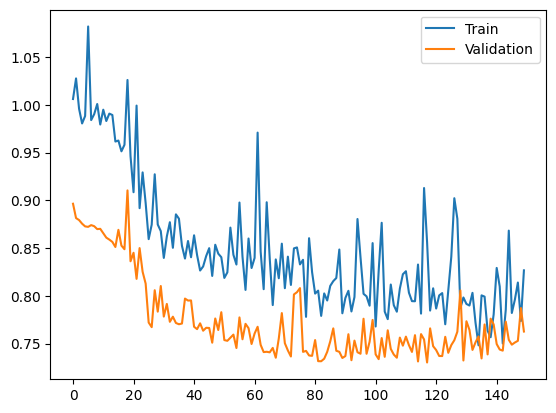

In [ ]:
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
plt.legend()

In [ ]:
model.eval()
y_pred_validation = model(X_validation_t)

In [ ]:
torch.mean(( y_validation_t - y_pred_validation )**2).item()
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

criterion = RMSELoss
loss = criterion(y_validation_t,y_pred_validation)
print(loss.item())

0.873236358165741


In [ ]:
X_train_t = smivec.transform(X_train, canonical=False)
X_train_t = torch.tensor(X_train_t, device=device).float()
y_train_t = torch.tensor(y_train, device=device).float()
y_train_t = torch.nan_to_num(y_train_t, nan = torch.nanmean(y_train_t))
X_test_t = smivec.transform(X_test, canonical=False)
X_test_t = torch.tensor(X_test_t, device=device).float()
y_test_t = torch.tensor(y_test, device=device).float()
y_test_t = torch.nan_to_num(y_test_t, nan = torch.nanmean(y_test_t))
y_pred_train = model(X_train_t)
y_pred_test = model(X_test_t)

In [ ]:
train_rmse = torch.mean(( y_train_t - y_pred_train )**2).item()
test_rmse = torch.mean(( y_test_t - y_pred_test )**2).item()
print("Train RMSE: %0.3F\tTest RMSE: %0.3F"%(train_rmse, test_rmse))

Train RMSE: 0.777	Test RMSE: 0.863


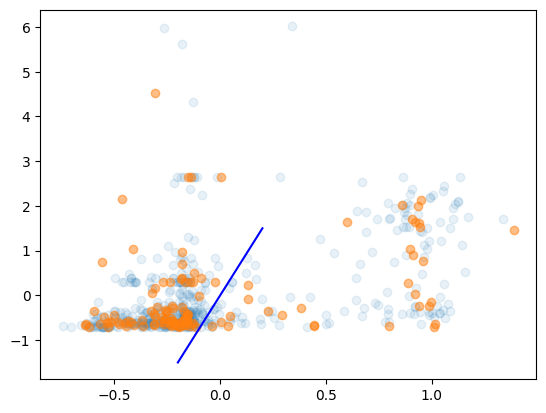

In [ ]:
plt.scatter(np.array(y_pred_train.tolist()).flatten(), np.array(y_train_t.tolist()).flatten(), alpha=0.1)
plt.scatter(np.array(y_pred_validation.tolist()).flatten(), np.array(y_validation_t.tolist()).flatten(), alpha=0.5)
plt.plot([-0.2, 0.2], [-1.5,1.5], c="b")